In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
from bs4 import BeautifulSoup
from PIL import Image
from PIL import ImageOps
from colormap import rgb2hex
import cv2
from scipy import cluster
from sklearn.preprocessing import MinMaxScaler
import imagesize
import random
from sklearn.preprocessing import LabelEncoder
from ipywidgets import interact
import time
from io import BytesIO
from keras.applications.vgg16 import VGG16
from keras.layers import Input
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from keras.utils import load_img, img_to_array
from tqdm.notebook import tqdm

In [3]:
pd.set_option('display.max_columns', None)

# Load raw data

In [4]:
PATH = 'Data/DeepFashion_categorical_images_low/'

In [5]:
cat_names = pd.read_csv('Data/DeepFashion_attributes - train/list_category.txt',sep ='\s+',header=None).reset_index().rename(columns={0:'category',1:'section','index':'cat_num'})



In [6]:
cat_names['cat_num'] = cat_names['cat_num'].apply(lambda x : x+1)

In [7]:
cat_names.head()

cat_num     category  section
0        1       Anorak        1
1        2       Blazer        1
2        3       Blouse        1
3        4       Bomber        1
4        5  Button-Down        1

In [8]:
cat_tag = pd.read_csv('Data/DeepFashion_attributes - train/tag_cat_simple.txt',sep='\s+',header=None,names=['category']).rename(columns={'category':'cat_num'})



In [9]:
cat_img = pd.read_csv('Data/DeepFashion_attributes - train/img_simple.txt',sep='\s+',header=None,names=['category']).rename(columns={'category':'img'})

In [10]:
cat_num = cat_img.join(cat_tag).drop(columns='img')


In [11]:
cat_num.head()

cat_num
0        3
1       33
2       41
3       26
4        2

In [12]:
cat = cat_num.merge(cat_names, on='cat_num', how='left').drop(columns='cat_num')



In [13]:
cat

category  section
0        Blouse        1
1         Skirt        2
2         Dress        3
3         Jeans        2
4        Blazer        1
...         ...      ...
19995      Tank        1
19996   Sweater        1
19997    Henley        1
19998  Jumpsuit        3
19999     Dress        3

[20000 rows x 2 columns]

In [14]:
cat['section'] = cat['section'].map({1:'upper',2:'lower',3:'full body'})

In [15]:
cat_names = pd.read_csv('Data/DeepFashion_attributes - train/list_category.txt',sep ='\s+',header=None).reset_index().rename(columns={0:'category',1:'section','index':'cat_num'})



In [16]:
cat_names['cat_num'] = cat_names['cat_num'].apply(lambda x : x+1)

In [17]:
cat_names.head()

cat_num     category  section
0        1       Anorak        1
1        2       Blazer        1
2        3       Blouse        1
3        4       Bomber        1
4        5  Button-Down        1

In [18]:
cat_tag = pd.read_csv('Data/DeepFashion_attributes - train/tag_cat_simple.txt',sep='\s+',header=None,names=['category']).rename(columns={'category':'cat_num'})



In [19]:
cat_img = pd.read_csv('Data/DeepFashion_attributes - train/img_simple.txt',sep='\s+',header=None,names=['category']).rename(columns={'category':'img'})

In [20]:
cat_num = cat_img.join(cat_tag)


In [21]:
cat_num.head()

img  cat_num
0          img/Sweet_Crochet_Blouse/img_00000070.jpg        3
1          img/Classic_Pencil_Skirt/img_00000010.jpg       33
2  img/Strapless_Diamond_Print_Dress/img_00000038...       41
3  img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_0000...       26
4  img/Zippered_Single-Button_Blazer/img_00000078...        2

In [22]:
cat = cat_num.merge(cat_names, on='cat_num', how='left').drop(columns='cat_num')


In [23]:
cat['img'] = cat['img'].apply(lambda x: x[4:])

In [24]:
cat

img  category  section
0                  Sweet_Crochet_Blouse/img_00000070.jpg    Blouse        1
1                  Classic_Pencil_Skirt/img_00000010.jpg     Skirt        2
2         Strapless_Diamond_Print_Dress/img_00000038.jpg     Dress        3
3      Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...     Jeans        2
4         Zippered_Single-Button_Blazer/img_00000078.jpg    Blazer        1
...                                                  ...       ...      ...
19995          Embroidered_Peasant_Tank/img_00000044.jpg      Tank        1
19996           Tasmanian_Devil_Sweater/img_00000048.jpg   Sweater        1
19997        Lace-Sleeved_Raglan_Henley/img_00000022.jpg    Henley        1
19998      Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg  Jumpsuit        3
19999            Sparkling_Ruched_Dress/img_00000047.jpg     Dress        3

[20000 rows x 3 columns]

In [25]:
cat['section'] = cat['section'].map({1:'upper',2:'lower',3:'full body'})

In [26]:
attr_names = pd.read_csv('Data/DeepFashion_attributes - train/list_attr_simple.txt',sep='\s+', header=None).rename(columns={0:'attribute',1:'attribute type'})


In [27]:
attr_names

attribute  attribute type
0            floral               1
1           graphic               1
2           striped               1
3       embroidered               1
4           pleated               1
5             solid               1
6           lattice               1
7       long_sleeve               2
8      short_sleeve               2
9        sleeveless               2
10      maxi_length               3
11      mini_length               3
12         no_dress               3
13    crew_neckline               4
14       v_neckline               4
15  square_neckline               4
16      no_neckline               4
17            denim               5
18          chiffon               5
19           cotton               5
20          leather               5
21             faux               5
22             knit               5
23            tight               6
24            loose               6
25     conventional               6

In [28]:
attr_names['attribute type'] = attr_names['attribute type'].map({1:'design',2:'sleeves',3:'length',4:'part',5:'fabric',6:'fit'})


In [29]:
attr_names_headers = attr_names.iloc[:,0]
attr_names_headers

0              floral
1             graphic
2             striped
3         embroidered
4             pleated
5               solid
6             lattice
7         long_sleeve
8        short_sleeve
9          sleeveless
10        maxi_length
11        mini_length
12           no_dress
13      crew_neckline
14         v_neckline
15    square_neckline
16        no_neckline
17              denim
18            chiffon
19             cotton
20            leather
21               faux
22               knit
23              tight
24              loose
25       conventional
Name: attribute, dtype: object

In [30]:
attr_tags = pd.read_csv('Data/DeepFashion_attributes - train/tags_attr_simple.txt',sep='\s+',header=None,names=attr_names_headers)


In [31]:
attr_tags

floral  graphic  striped  embroidered  pleated  solid  lattice  \
0           0        0        0            1        0      0        0   
1           0        0        0            0        0      1        0   
2           0        1        0            0        0      0        0   
3           0        0        0            0        0      1        0   
4           0        0        0            0        0      1        0   
...       ...      ...      ...          ...      ...    ...      ...   
19995       0        0        0            1        0      0        0   
19996       0        0        0            0        0      1        0   
19997       0        0        1            0        0      0        0   
19998       1        0        0            0        0      0        0   
19999       0        0        0            1        0      0        0   

       long_sleeve  short_sleeve  sleeveless  maxi_length  mini_length  \
0                0             0           1            0            0   
1                0             0           1            0            0   
2                0             0           1            1            0   
3                0             0           1            0            0   
4                1             0           0            0            0   
...            ...           ...         ...          ...          ...   
19995            0             0           1            0            0   
19996            1             0           0            0            0   
19997            1             0           0            0            0   
19998            0             1           0            0            0   
19999            0             0           1            0            1   

       no_dress  crew_neckline  v_neckline  square_neckline  no_neckline  \
0             1              0           0                0            1   
1             1              0           0                0            1   
2             0              0           0                0            1   
3             1              0           0                0            1   
4             1              0           1                0            0   
...         ...            ...         ...              ...          ...   
19995         1              0           1                0            0   
19996         1              0           1                0            0   
19997         1              1           0                0            0   
19998         1              0           1                0            0   
19999         0              0           0                0            1   

       denim  chiffon  cotton  leather  faux  knit  tight  loose  conventional  
0          0        1       0        0     0     0      0      0             1  
1          0        0       1        0     0     0      1      0             0  
2          0        0       1        0     0     0      0      0             1  
3          1        0       0        0     0     0      1      0             0  
4          0        0       1        0     0     0      0      0             1  
...      ...      ...     ...      ...   ...   ...    ...    ...           ...  
19995      0        0       1        0     0     0      0      0             1  
19996      0        0       0        0     0     1      0      0             1  
19997      0        0       1        0     0     0      0      0             1  
19998      0        0       1        0     0     0      0      0             1  
19999      0        1       0        0     0     0      0      0             1  

[20000 rows x 26 columns]

In [32]:
attr_img = pd.read_csv('Data/DeepFashion_attributes - train/img_simple.txt',sep='\s+',header=None).rename(columns={0:'img'})



In [33]:
attr_img

img
0              img/Sweet_Crochet_Blouse/img_00000070.jpg
1              img/Classic_Pencil_Skirt/img_00000010.jpg
2      img/Strapless_Diamond_Print_Dress/img_00000038...
3      img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_0000...
4      img/Zippered_Single-Button_Blazer/img_00000078...
...                                                  ...
19995      img/Embroidered_Peasant_Tank/img_00000044.jpg
19996       img/Tasmanian_Devil_Sweater/img_00000048.jpg
19997    img/Lace-Sleeved_Raglan_Henley/img_00000022.jpg
19998  img/Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg
19999        img/Sparkling_Ruched_Dress/img_00000047.jpg

[20000 rows x 1 columns]

In [34]:
attr = attr_img.join(attr_tags,how='inner').drop(columns='img')

In [35]:
attr

floral  graphic  striped  embroidered  pleated  solid  lattice  \
0           0        0        0            1        0      0        0   
1           0        0        0            0        0      1        0   
2           0        1        0            0        0      0        0   
3           0        0        0            0        0      1        0   
4           0        0        0            0        0      1        0   
...       ...      ...      ...          ...      ...    ...      ...   
19995       0        0        0            1        0      0        0   
19996       0        0        0            0        0      1        0   
19997       0        0        1            0        0      0        0   
19998       1        0        0            0        0      0        0   
19999       0        0        0            1        0      0        0   

       long_sleeve  short_sleeve  sleeveless  maxi_length  mini_length  \
0                0             0           1            0            0   
1                0             0           1            0            0   
2                0             0           1            1            0   
3                0             0           1            0            0   
4                1             0           0            0            0   
...            ...           ...         ...          ...          ...   
19995            0             0           1            0            0   
19996            1             0           0            0            0   
19997            1             0           0            0            0   
19998            0             1           0            0            0   
19999            0             0           1            0            1   

       no_dress  crew_neckline  v_neckline  square_neckline  no_neckline  \
0             1              0           0                0            1   
1             1              0           0                0            1   
2             0              0           0                0            1   
3             1              0           0                0            1   
4             1              0           1                0            0   
...         ...            ...         ...              ...          ...   
19995         1              0           1                0            0   
19996         1              0           1                0            0   
19997         1              1           0                0            0   
19998         1              0           1                0            0   
19999         0              0           0                0            1   

       denim  chiffon  cotton  leather  faux  knit  tight  loose  conventional  
0          0        1       0        0     0     0      0      0             1  
1          0        0       1        0     0     0      1      0             0  
2          0        0       1        0     0     0      0      0             1  
3          1        0       0        0     0     0      1      0             0  
4          0        0       1        0     0     0      0      0             1  
...      ...      ...     ...      ...   ...   ...    ...    ...           ...  
19995      0        0       1        0     0     0      0      0             1  
19996      0        0       0        0     0     1      0      0             1  
19997      0        0       1        0     0     0      0      0             1  
19998      0        0       1        0     0     0      0      0             1  
19999      0        1       0        0     0     0      0      0             1  

[20000 rows x 26 columns]

In [36]:
bb = pd.read_csv('Data/DeepFashion_attributes - train/bbox.txt',sep='\s+',header=None,index_col=False, names=['img','x_1', 'y_1', 'x_2', 'y_2'])


In [37]:
bb['img'] = bb['img'].apply(lambda x: x[4:])

In [38]:
landmarks = pd.read_csv('Data/DeepFashion_attributes - train/landmarks.txt',sep='\s+',names=['img','clothes_type','v1','x1','y1','v2','x2','y2','v3','x3','y3','v4','x4','y4','v5','x5','y5','v6','x6','y6','v7','x7','y7','v8','x8','y8']).fillna(0).drop(columns=['clothes_type'])



In [39]:
landmarks['img'] = landmarks['img'].apply(lambda x: x[4:])

In [40]:
data_full = cat.join(attr,how='left').merge(bb,how='left',on='img').merge(landmarks, how='left',on='img')



# Filter attributes

In [41]:
data_full

img  category    section  \
0                  Sweet_Crochet_Blouse/img_00000070.jpg    Blouse      upper   
1                  Classic_Pencil_Skirt/img_00000010.jpg     Skirt      lower   
2         Strapless_Diamond_Print_Dress/img_00000038.jpg     Dress  full body   
3      Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...     Jeans      lower   
4         Zippered_Single-Button_Blazer/img_00000078.jpg    Blazer      upper   
...                                                  ...       ...        ...   
19995          Embroidered_Peasant_Tank/img_00000044.jpg      Tank      upper   
19996           Tasmanian_Devil_Sweater/img_00000048.jpg   Sweater      upper   
19997        Lace-Sleeved_Raglan_Henley/img_00000022.jpg    Henley      upper   
19998      Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg  Jumpsuit  full body   
19999            Sparkling_Ruched_Dress/img_00000047.jpg     Dress  full body   

       floral  graphic  striped  embroidered  pleated  solid  lattice  \
0           0        0        0            1        0      0        0   
1           0        0        0            0        0      1        0   
2           0        1        0            0        0      0        0   
3           0        0        0            0        0      1        0   
4           0        0        0            0        0      1        0   
...       ...      ...      ...          ...      ...    ...      ...   
19995       0        0        0            1        0      0        0   
19996       0        0        0            0        0      1        0   
19997       0        0        1            0        0      0        0   
19998       1        0        0            0        0      0        0   
19999       0        0        0            1        0      0        0   

       long_sleeve  short_sleeve  sleeveless  maxi_length  mini_length  \
0                0             0           1            0            0   
1                0             0           1            0            0   
2                0             0           1            1            0   
3                0             0           1            0            0   
4                1             0           0            0            0   
...            ...           ...         ...          ...          ...   
19995            0             0           1            0            0   
19996            1             0           0            0            0   
19997            1             0           0            0            0   
19998            0             1           0            0            0   
19999            0             0           1            0            1   

       no_dress  crew_neckline  v_neckline  square_neckline  no_neckline  \
0             1              0           0                0            1   
1             1              0           0                0            1   
2             0              0           0                0            1   
3             1              0           0                0            1   
4             1              0           1                0            0   
...         ...            ...         ...              ...          ...   
19995         1              0           1                0            0   
19996         1              0           1                0            0   
19997         1              1           0                0            0   
19998         1              0           1                0            0   
19999         0              0           0                0            1   

       denim  chiffon  cotton  leather  faux  knit  tight  loose  \
0          0        1       0        0     0     0      0      0   
1          0        0       1        0     0     0      1      0   
2          0        0       1        0     0     0      0      0   
3          1        0       0        0     0     0      1      0   
4          0        0       1        0     0     0      0    

In [42]:
# If item is sleevless and of lower type, set attribute value to 0:
data_full['sleeveless'] = data_full.apply(lambda x: 0 if ((x['sleeveless'])==1) & (x['section']=='lower') else x['sleeveless'], axis =1)


In [43]:
data_full

img  category    section  \
0                  Sweet_Crochet_Blouse/img_00000070.jpg    Blouse      upper   
1                  Classic_Pencil_Skirt/img_00000010.jpg     Skirt      lower   
2         Strapless_Diamond_Print_Dress/img_00000038.jpg     Dress  full body   
3      Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...     Jeans      lower   
4         Zippered_Single-Button_Blazer/img_00000078.jpg    Blazer      upper   
...                                                  ...       ...        ...   
19995          Embroidered_Peasant_Tank/img_00000044.jpg      Tank      upper   
19996           Tasmanian_Devil_Sweater/img_00000048.jpg   Sweater      upper   
19997        Lace-Sleeved_Raglan_Henley/img_00000022.jpg    Henley      upper   
19998      Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg  Jumpsuit  full body   
19999            Sparkling_Ruched_Dress/img_00000047.jpg     Dress  full body   

       floral  graphic  striped  embroidered  pleated  solid  lattice  \
0           0        0        0            1        0      0        0   
1           0        0        0            0        0      1        0   
2           0        1        0            0        0      0        0   
3           0        0        0            0        0      1        0   
4           0        0        0            0        0      1        0   
...       ...      ...      ...          ...      ...    ...      ...   
19995       0        0        0            1        0      0        0   
19996       0        0        0            0        0      1        0   
19997       0        0        1            0        0      0        0   
19998       1        0        0            0        0      0        0   
19999       0        0        0            1        0      0        0   

       long_sleeve  short_sleeve  sleeveless  maxi_length  mini_length  \
0                0             0           1            0            0   
1                0             0           0            0            0   
2                0             0           1            1            0   
3                0             0           0            0            0   
4                1             0           0            0            0   
...            ...           ...         ...          ...          ...   
19995            0             0           1            0            0   
19996            1             0           0            0            0   
19997            1             0           0            0            0   
19998            0             1           0            0            0   
19999            0             0           1            0            1   

       no_dress  crew_neckline  v_neckline  square_neckline  no_neckline  \
0             1              0           0                0            1   
1             1              0           0                0            1   
2             0              0           0                0            1   
3             1              0           0                0            1   
4             1              0           1                0            0   
...         ...            ...         ...              ...          ...   
19995         1              0           1                0            0   
19996         1              0           1                0            0   
19997         1              1           0                0            0   
19998         1              0           1                0            0   
19999         0              0           0                0            1   

       denim  chiffon  cotton  leather  faux  knit  tight  loose  \
0          0        1       0        0     0     0      0      0   
1          0        0       1        0     0     0      1      0   
2          0        0       1        0     0     0      0      0   
3          1        0       0        0     0     0      1      0   
4          0        0       1        0     0     0      0    

In [44]:
data_full.drop(columns=['no_dress','no_neckline'],inplace=True)

# Crop and augment images

In [45]:
data_full

img  category    section  \
0                  Sweet_Crochet_Blouse/img_00000070.jpg    Blouse      upper   
1                  Classic_Pencil_Skirt/img_00000010.jpg     Skirt      lower   
2         Strapless_Diamond_Print_Dress/img_00000038.jpg     Dress  full body   
3      Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...     Jeans      lower   
4         Zippered_Single-Button_Blazer/img_00000078.jpg    Blazer      upper   
...                                                  ...       ...        ...   
19995          Embroidered_Peasant_Tank/img_00000044.jpg      Tank      upper   
19996           Tasmanian_Devil_Sweater/img_00000048.jpg   Sweater      upper   
19997        Lace-Sleeved_Raglan_Henley/img_00000022.jpg    Henley      upper   
19998      Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg  Jumpsuit  full body   
19999            Sparkling_Ruched_Dress/img_00000047.jpg     Dress  full body   

       floral  graphic  striped  embroidered  pleated  solid  lattice  \
0           0        0        0            1        0      0        0   
1           0        0        0            0        0      1        0   
2           0        1        0            0        0      0        0   
3           0        0        0            0        0      1        0   
4           0        0        0            0        0      1        0   
...       ...      ...      ...          ...      ...    ...      ...   
19995       0        0        0            1        0      0        0   
19996       0        0        0            0        0      1        0   
19997       0        0        1            0        0      0        0   
19998       1        0        0            0        0      0        0   
19999       0        0        0            1        0      0        0   

       long_sleeve  short_sleeve  sleeveless  maxi_length  mini_length  \
0                0             0           1            0            0   
1                0             0           0            0            0   
2                0             0           1            1            0   
3                0             0           0            0            0   
4                1             0           0            0            0   
...            ...           ...         ...          ...          ...   
19995            0             0           1            0            0   
19996            1             0           0            0            0   
19997            1             0           0            0            0   
19998            0             1           0            0            0   
19999            0             0           1            0            1   

       crew_neckline  v_neckline  square_neckline  denim  chiffon  cotton  \
0                  0           0                0      0        1       0   
1                  0           0                0      0        0       1   
2                  0           0                0      0        0       1   
3                  0           0                0      1        0       0   
4                  0           1                0      0        0       1   
...              ...         ...              ...    ...      ...     ...   
19995              0           1                0      0        0       1   
19996              0           1                0      0        0       0   
19997              1           0                0      0        0       1   
19998              0           1                0      0        0       1   
19999              0           0                0      0        1       0   

       leather  faux  knit  tight  loose  conventional  x_1  y_1  x_2  y_2  \
0            0     0     0      0      0             1   66   75  241  293   
1            0     0     0      1      0             0   65   88  132  218   
2            0     0     0      0      0             1   75   43  176  300   
3            0     0     0      1      0             0   64    1  129  273   

In [46]:
data_full_attr = data_full.iloc[:,3:-28]

In [47]:
data_full_attr

floral  graphic  striped  embroidered  pleated  solid  lattice  \
0           0        0        0            1        0      0        0   
1           0        0        0            0        0      1        0   
2           0        1        0            0        0      0        0   
3           0        0        0            0        0      1        0   
4           0        0        0            0        0      1        0   
...       ...      ...      ...          ...      ...    ...      ...   
19995       0        0        0            1        0      0        0   
19996       0        0        0            0        0      1        0   
19997       0        0        1            0        0      0        0   
19998       1        0        0            0        0      0        0   
19999       0        0        0            1        0      0        0   

       long_sleeve  short_sleeve  sleeveless  maxi_length  mini_length  \
0                0             0           1            0            0   
1                0             0           0            0            0   
2                0             0           1            1            0   
3                0             0           0            0            0   
4                1             0           0            0            0   
...            ...           ...         ...          ...          ...   
19995            0             0           1            0            0   
19996            1             0           0            0            0   
19997            1             0           0            0            0   
19998            0             1           0            0            0   
19999            0             0           1            0            1   

       crew_neckline  v_neckline  square_neckline  denim  chiffon  cotton  \
0                  0           0                0      0        1       0   
1                  0           0                0      0        0       1   
2                  0           0                0      0        0       1   
3                  0           0                0      1        0       0   
4                  0           1                0      0        0       1   
...              ...         ...              ...    ...      ...     ...   
19995              0           1                0      0        0       1   
19996              0           1                0      0        0       0   
19997              1           0                0      0        0       1   
19998              0           1                0      0        0       1   
19999              0           0                0      0        1       0   

       leather  faux  knit  tight  loose  conventional  
0            0     0     0      0      0             1  
1            0     0     0      1      0             0  
2            0     0     0      0      0             1  
3            0     0     0      1      0             0  
4            0     0     0      0      0             1  
...        ...   ...   ...    ...    ...           ...  
19995        0     0     0      0      0             1  
19996        0     0     1      0      0             1  
19997        0     0     0      0      0             1  
19998        0     0     0      0      0             1  
19999        0     0     0      0      0             1  

[20000 rows x 24 columns]

In [48]:
attribute_count = data_full_attr.apply(pd.value_counts)

In [49]:
attribute_count_T = attribute_count.T.reset_index().rename(columns={'index':'attribute'})

In [50]:
attribute_count_T

attribute      0      1
0            floral  16598   3402
1           graphic  16654   3346
2           striped  18653   1347
3       embroidered  18333   1667
4           pleated  19586    414
5             solid  10518   9482
6           lattice  19658    342
7       long_sleeve  13883   6117
8      short_sleeve  16526   3474
9        sleeveless  13365   6635
10      maxi_length  17971   2029
11      mini_length  16166   3834
12    crew_neckline  11914   8086
13       v_neckline  16542   3458
14  square_neckline  19939     61
15            denim  18806   1194
16          chiffon  17115   2885
17           cotton   6396  13604
18          leather  19594    406
19             faux  19811    189
20             knit  18278   1722
21            tight  17109   2891
22            loose  18931   1069
23     conventional   3960  16040

In [51]:
attribute_count_type = attribute_count_T.merge(attr_names, on='attribute')

In [52]:
attribute_count_type

attribute      0      1 attribute type
0            floral  16598   3402         design
1           graphic  16654   3346         design
2           striped  18653   1347         design
3       embroidered  18333   1667         design
4           pleated  19586    414         design
5             solid  10518   9482         design
6           lattice  19658    342         design
7       long_sleeve  13883   6117        sleeves
8      short_sleeve  16526   3474        sleeves
9        sleeveless  13365   6635        sleeves
10      maxi_length  17971   2029         length
11      mini_length  16166   3834         length
12    crew_neckline  11914   8086           part
13       v_neckline  16542   3458           part
14  square_neckline  19939     61           part
15            denim  18806   1194         fabric
16          chiffon  17115   2885         fabric
17           cotton   6396  13604         fabric
18          leather  19594    406         fabric
19             faux  19811    189         fabric
20             knit  18278   1722         fabric
21            tight  17109   2891            fit
22            loose  18931   1069            fit
23     conventional   3960  16040            fit

In [53]:
attribute_count_type_mean = attribute_count_type.groupby('attribute type').median().drop(columns=0)

In [54]:
attribute_count_type_mean

1
attribute type        
design          1667.0
fabric          1458.0
fit             2891.0
length          2931.5
part            3458.0
sleeves         6117.0

In [55]:
attribute_count_mean = attribute_count_type[1].median()
attribute_count_mean

2888.0

In [56]:
attr_names_list = attribute_count_type['attribute'].values
attr_names_list

array(['floral', 'graphic', 'striped', 'embroidered', 'pleated', 'solid',
       'lattice', 'long_sleeve', 'short_sleeve', 'sleeveless',
       'maxi_length', 'mini_length', 'crew_neckline', 'v_neckline',
       'square_neckline', 'denim', 'chiffon', 'cotton', 'leather', 'faux',
       'knit', 'tight', 'loose', 'conventional'], dtype=object)

In [57]:
def landmark_crop(index): # NOT USED AT THE MOMENT !
    observation = data_full.iloc[index,:] # get observation from database according to index
    v1,x1,y1,v2,x2,y2,v3,x3,y3,v4,x4,y4=observation[-24:-12] # landmarks belonging to ALL images
    lm_x = [x1,x2,x3,x4]
    lm_y = [y1,y2,y3,y4]
    lm_v = [v1,v2,v3,v4]
    
    section = data_full.iloc[index,2] # get section type for image
    if section == 'upper' or section == 'full body': # if image is an upper or full body, has 6 landmarks
        v5,x5,y5,v6,x6,y6=observation[-12:-6]
        lm_x.extend([x5,x6])
        lm_y.extend([y5,y6])
        lm_v.extend([v5,v6])
    if section == 'full body': # if image is full body has 8 landmarks
        v7,x7,y7,v8,x8,y8=observation[-6:]
        lm_x.extend([x7,x8])
        lm_y.extend([y7,y8])
        lm_v.extend([v7,v8])
    
    lm_x = np.array(lm_x)
    lm_y = np.array(lm_y)
    lm_x = lm_x[lm_x !=0] # keep only non-zero landmarks 
    lm_y = lm_y[lm_y !=0]
    
    pts = (np.array(list(zip(lm_x,lm_y)))).astype('int') # store coordinates defined by landmarks
    
    img_name = observation[0]
    full_path = PATH+img_name
    
    img = cv2.imread(full_path) # open image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image to correct format
    
    x,y,w,h = cv2.boundingRect(pts) # create approximate rectangle using landmark points
    cropped = Image.fromarray(img[y:y+h, x:x+w].copy()) # crop image by bounding rectangle

    return cropped
    

In [58]:
def format_image(index): # format image
    observation = data_full.iloc[index,:] # get observation from database according to index    
    img_name = observation[0]
    full_path = PATH+img_name
    
    img = cv2.imread(full_path) # open image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # CROP IMAGES:
    plt.imshow(img)
    box_x1,box_y1,box_x2,box_y2 = (np.array(observation[-28:-24].values)) # box coords
    cropped = Image.fromarray(img[box_y1:box_y2, box_x1:box_x2].copy()) # crop image using box

    # PAD IMAGES:
    cropped_pad = ImageOps.pad(cropped,(256,256),color=(255, 255, 255)) # pad image to (256,256) with white background
    plt.imshow(cropped_pad)
    
    # AUGMENT IMAGES:
#     # Create an ImageDataGenerator object with the desired transformations
#     datagen = ImageDataGenerator(
#         rotation_range=40,
#         zoom_range=0.2,
#         horizontal_flip=True
#     )
#     # Load the original image
#     image = im_pad
#     # Convert the image to a Numpy array
#     x = img_to_array(image)
#     # Reshape the array to include an extra dimension for the number of images
#     x = x.reshape((1,) + x.shape)
#     # Generate the augmented images and save them
#     i = 0
#     for batch in datagen.flow(x, batch_size=1, save_to_dir=PATH, save_format='jpg'):
#         i += 1
#         if i >= 10:
#             break
    return cropped_pad


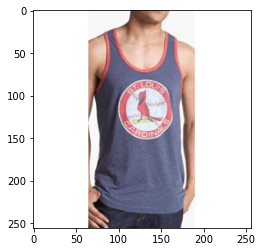

In [59]:
sample_index = np.random.randint(20000)
image = format_image(sample_index)

plt.imshow(image)

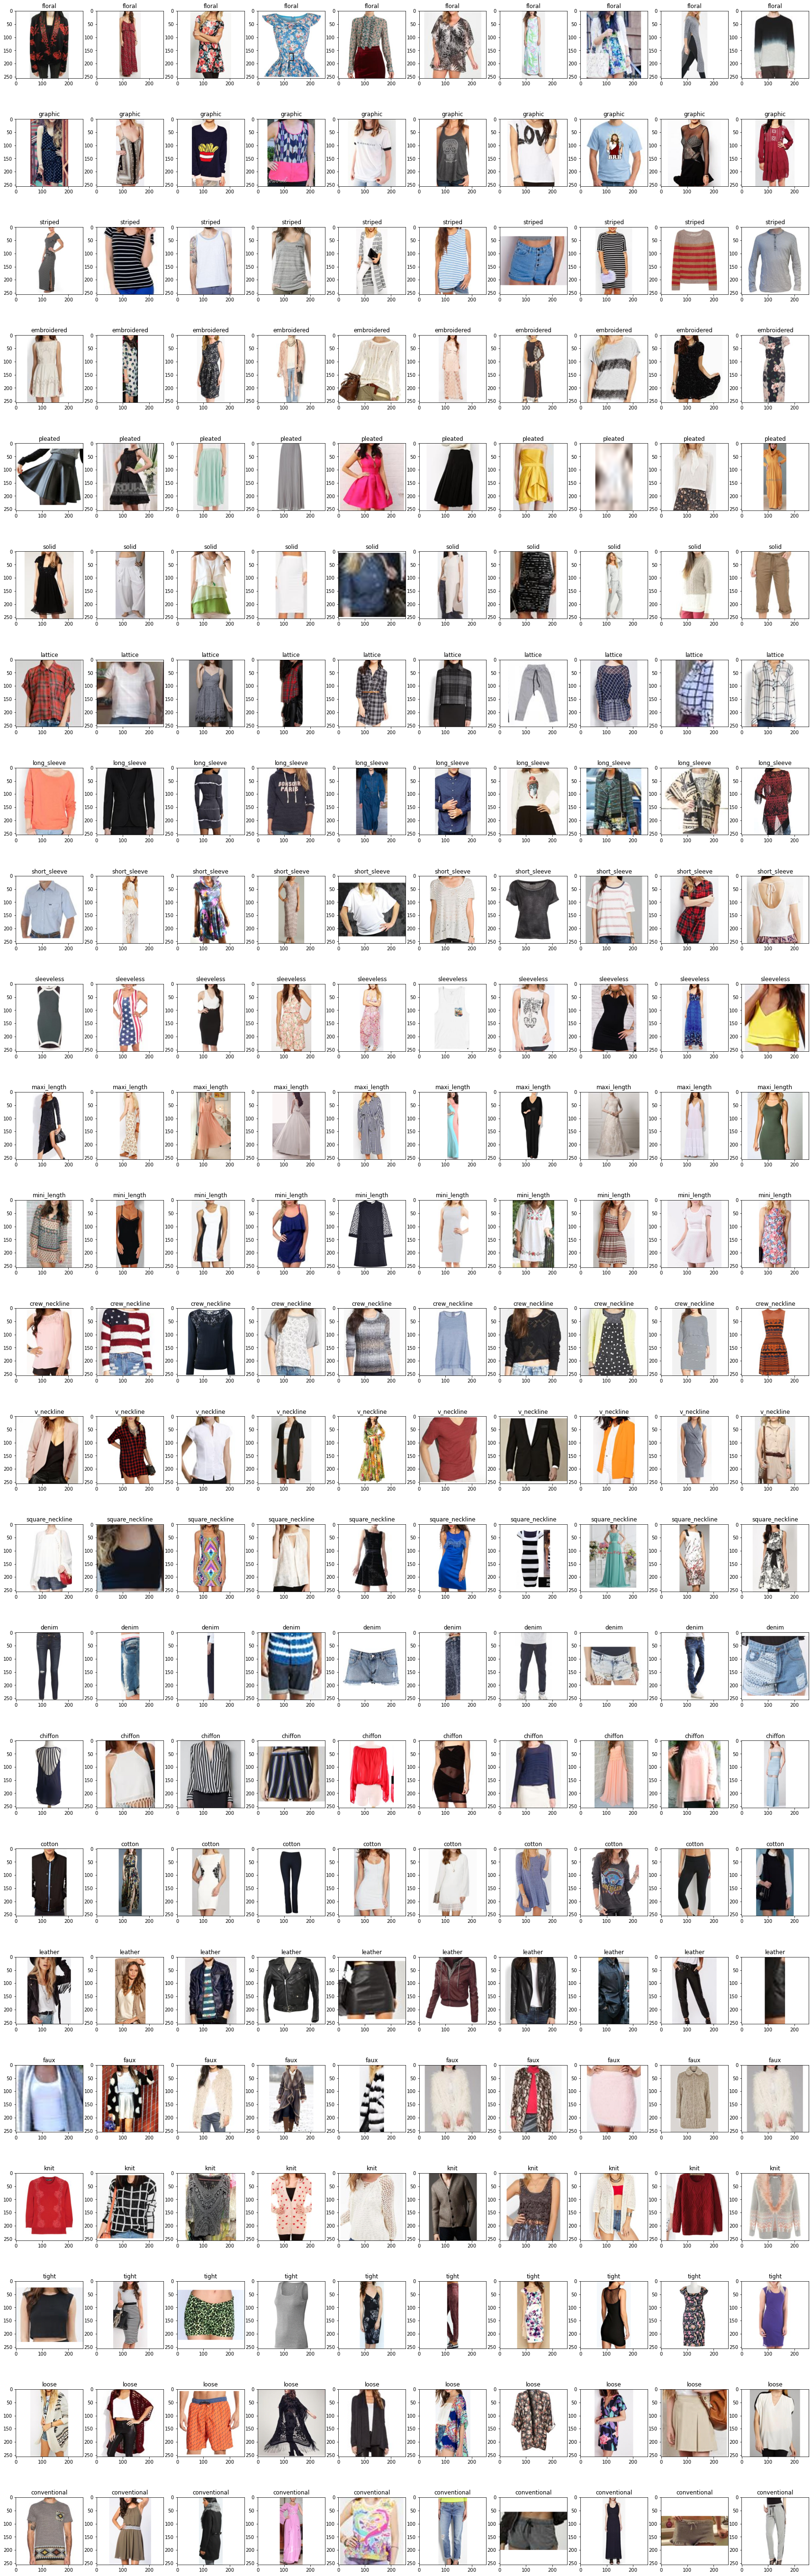

In [60]:
fig, axs = plt.subplots(24,10,figsize=(30,100))
for i in range(24):
    for j in range(10):
        index = data_full[data_full[attr_names_list[i]]==1].sample(1).index._data[0]
        img = format_image(index)
        img = axs[i][j].imshow(img)
        axs[i][j].title.set_text(attr_names_list[i])

In [61]:
def landmark_crop(index): # NOT USED AT THE MOMENT !
    observation = data_full.iloc[index,:] # get observation from database according to index
    v1,x1,y1,v2,x2,y2,v3,x3,y3,v4,x4,y4=observation[-24:-12] # landmarks belonging to ALL images
    lm_x = [x1,x2,x3,x4]
    lm_y = [y1,y2,y3,y4]
    lm_v = [v1,v2,v3,v4]
    
    section = data_full.iloc[index,2] # get section type for image
    if section == 'upper' or section == 'full body': # if image is an upper or full body, has 6 landmarks
        v5,x5,y5,v6,x6,y6=observation[-12:-6]
        lm_x.extend([x5,x6])
        lm_y.extend([y5,y6])
        lm_v.extend([v5,v6])
    if section == 'full body': # if image is full body has 8 landmarks
        v7,x7,y7,v8,x8,y8=observation[-6:]
        lm_x.extend([x7,x8])
        lm_y.extend([y7,y8])
        lm_v.extend([v7,v8])
    
    lm_x = np.array(lm_x)
    lm_y = np.array(lm_y)
    lm_x = lm_x[lm_x !=0] # keep only non-zero landmarks 
    lm_y = lm_y[lm_y !=0]
    
    pts = (np.array(list(zip(lm_x,lm_y)))).astype('int') # store coordinates defined by landmarks
    
    img_name = observation[0]
    full_path = PATH+img_name
    
    img = cv2.imread(full_path) # open image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image to correct format
    
    x,y,w,h = cv2.boundingRect(pts) # create approximate rectangle using landmark points
    cropped = Image.fromarray(img[y:y+h, x:x+w].copy()) # crop image by bounding rectangle

    return cropped
    

# Attribute model testing 

In [69]:
def format_image(img_name,box_x1,box_y1,box_x2,box_y2): # format image
    full_path = PATH+img_name
    
    # LOAD IMAGES:
    img = cv2.imread(full_path) # open image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # CROP IMAGES:
    cropped = Image.fromarray(img[box_y1:box_y2, box_x1:box_x2].copy()) # crop image using box
    
    # PAD IMAGES:
    cropped_pad = ImageOps.pad(cropped,(256,256),color=(255)) # pad image to (256,256) with white background
    
    cropped_pad_array = img_to_array(cropped_pad)
    
    return cropped_pad_array

## Without image augmentation

### Fabric

In [63]:
fabric_data = data_full.iloc[:,np.r_[0,18:24,27:31]] # select all attributes related to fabric

In [65]:
fabric_X_names = fabric_data.iloc[:,np.r_[0,7,8,9,10]]

In [70]:
fabric_X = np.array([format_image(fabric_X_name[0], *fabric_X_name[1:]) for fabric_X_name in tqdm(fabric_X_names.values)])




  0%|          | 0/20000 [00:00<?, ?it/s]

In [67]:
fabric_X.shape

(20000, 256, 256, 1)

In [71]:
fabric_y = fabric_data.iloc[:,1:]

In [72]:
fabric_X_train, fabric_X_test, fabric_y_train, fabric_y_test = train_test_split(fabric_X, fabric_y, test_size =0.2,random_state=2)


In [73]:
fabric_X_train, fabric_X_val, fabric_y_train, fabric_y_val = train_test_split(fabric_X_train, fabric_y_train, test_size =0.2,random_state=2)



KeyboardInterrupt



In [183]:
fabric_X_train

13855                             Utility_Romper/img_00000050.jpg
10567           Pintucked_Crochet-Paneled_Blouse/img_00000017.jpg
8573                         Lace_Trimmed_Blouse/img_00000037.jpg
19782                  Mesh_Overlay_Sheath_Dress/img_00000037.jpg
13586    Fringed_Southwestern-Embroidered_Kimono/img_00000012.jpg
                                   ...                           
14402                Textured_Diamond_Knit_Dress/img_00000049.jpg
12692             Embroidered_Cutout_Smock_Dress/img_00000049.jpg
418                 Crisscross-Back_Skater_Dress/img_00000030.jpg
1939                      Kaleidoscope_Woven_Tee/img_00000020.jpg
3639                Two-Button_Chino_Suit_Jacket/img_00000062.jpg
Name: img, Length: 12800, dtype: object

#### VGG16

In [68]:
# Training image size --> (256,256,3)

In [137]:
fabric_input = Input(shape=(640, 480, 3))
model = VGG16(include_top=False, input_tensor=new_input)

NameError: name 'Input' is not defined